In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch.utils.data.dataloader as dataloader

import math
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
from tqdm.notebook import trange, tqdm


### Hyper parameters

In [3]:
batch_size = 128
num_epochs = 50
learning_rate = 1e-4

data_set_root = "../../datasets"

patch_size = 4

In [4]:
gpu_idx = 0
device = torch.device(gpu_idx if torch.cuda.is_available() else 'cpu')

### Create a transform for input data

In [5]:
transform = transforms.Compose([transforms.AutoAugment(transforms.AutoAugmentPolicy.CIFAR10), 
                                transforms.ToTensor(),
                                transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                     std=[0.229, 0.224, 0.225])])

test_transform = transforms.Compose([transforms.ToTensor(),
                                     transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                          std=[0.229, 0.224, 0.225])])

### Creating the training, testing and validation data

In [6]:
train_data = datasets.CIFAR10(data_set_root, train=True, download=True, transform=transform)
test_data = datasets.CIFAR10(data_set_root, train=False, download=True, transform=test_transform)

validation_split = 0.9

n_train_examples = int(len(train_data) * validation_split)
n_val_examples = len(train_data) - n_train_examples

train_data, val_data = torch.utils.data.random_split(train_data, [n_train_examples, n_val_examples],
                                                     generator=torch.Generator().manual_seed(42))


train_loader = dataloader.DataLoader(train_data, shuffle=True, batch_size=batch_size)
val_loader = dataloader.DataLoader(val_data, batch_size=batch_size)
test_loader = dataloader.DataLoader(test_data, batch_size=batch_size)

100%|██████████| 170M/170M [03:50<00:00, 739kB/s]  


Extracting ../../datasets/cifar-10-python.tar.gz to ../../datasets
Files already downloaded and verified


In [7]:
print(f'Number of training examples: {len(train_data)}')
print(f'Number of validation examples: {len(val_data)}')
print(f'Number of test examples: {len(test_data)}')

Number of training examples: 45000
Number of validation examples: 5000
Number of test examples: 10000


In [8]:
def extract_patches(image_tensor, patch_size=8):
    # getting the dimensions of the image tensor
    bs, c, h, w = image_tensor.size()

    # defining the unfold layer with appropriate parameters
    unfold = torch.nn.Unfold(kernel_size=patch_size, stride=patch_size)

    # applying unfold to image tensor
    unfolded = unfold(image_tensor)

    # reshaping unfolded tensor to match desired output shape
    # output shape: BSxLxH where L is number of patches in each dimension
    unfolded = unfolded.transpose(1, 2).reshape(bs, -1, c * patch_size * patch_size)

    return unfolded

### View Image Patches

In [10]:
dataiter = next(iter(test_loader))
test_images, test_labels = dataiter

Sequence Length 64


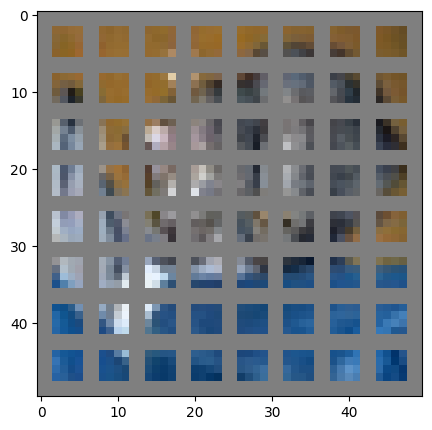

In [11]:
patches = extract_patches(test_images, patch_size=patch_size)
patches_square = patches.reshape(test_images.shape[0], -1, 3, patch_size, patch_size)

grid_size = test_images.shape[2] // patch_size
print(f'Sequence Length {grid_size ** 2}')

plt.figure(figsize=(5, 5))
out = torchvision.utils.make_grid(patches_square[0], grid_size, normalize=True, pad_value=0.5)
_ = plt.imshow(out.numpy().transpose((1, 2, 0)))

### Creating the Vision Transformer network

In [13]:
# creating transformer block with self attention
class TransformerBlock(nn.Module):
    def __init__(self, hidden_size=128, num_heads=4):
        super(TransformerBlock, self).__init__()

        # layer normalisation to normalize input data
        self.norm1 = nn.LayerNorm(hidden_size)

        # multi head attention mechanism
        self.multihead_attn = nn.MultiheadAttention(hidden_size, num_heads=num_heads,
                                                    batch_first=True, dropout=0.1)
        
        # another layer normalization
        self.norm2 = nn.LayerNorm(hidden_size)

        # multi-layer perceptron (MLP) with a hidden layer and activation function
        self.mlp = nn.Sequential(
            nn.Linear(hidden_size, hidden_size * 2),
            nn.LayerNorm(hidden_size * 2),
            nn.ELU(),
            nn.Linear(hidden_size * 2, hidden_size)
        )

    def forward(self, x):
        # applying first layer normalization
        norm_x = self.norm1(x)

        # applying multi-head attention and add input (residual connection)
        x = self.multihead_attn(norm_x, norm_x, norm_x)[0] + x

        # applying the second layer normalization
        norm_x = self.norm2(x)

        # passing through MLP and adding input (residual connection)
        x = self.mlp(norm_x) + x

        return x
    
class ViT(nn.Module):
    def __init__(self, image_size, channels_in, patch_size, hidden_size, num_layers, num_heads=8):

        # calling the __init__ function of the parent nn.Module class
        super(ViT, self).__init__()

        self.patch_size = patch_size

        # fully connected layer to project input patches to the hidden size dimension
        self.fc_in = nn.Linear(channels_in * patch_size * patch_size, hidden_size)

        # create list of transformer blocks
        self.blocks = nn.ModuleList([
            TransformerBlock(hidden_size, num_heads) for _ in range(num_layers)
        ])

        # fully connected output layer to map number of classes (eg. 10 for CIFAR10)
        self.fc_out = nn.Linear(hidden_size, 10)

        # parameter for output token
        self.out_vec = nn.Parameter(torch.zeros(1, 1, hidden_size))

        # positional embeddings to retain positional information of patches
        seq_length = (image_size // patch_size) ** 2
        self.pos_embedding = nn.Parameter(torch.empty(1, seq_length, hidden_size).normal_(std=0.001))

    def forward(self, image):
        bs = image.shape[0]

        # extracting patches from image and flattening them
        patch_seq = extract_patches(image, patch_size=self.patch_size)

        # projecting patches to hidden size dimension
        patch_emb = self.fc_in(patch_seq)

        # adding positional embeddings to the patch embeddings
        patch_emb = patch_emb + self.pos_embedding

        # concatenating the output token to patch embeddings
        embs = torch.cat((self.out_vec.expand(bs, 1, -1), patch_emb), 1)

        # passing embeddings through each Transformer block
        for block in self.blocks:
            embs = block(embs)

        # using embedding of output token for classification
        return self.fc_out(embs[:, 0])                                          

### Create our model and view the output!

In [14]:
dataiter = next(iter(train_loader))
train_images, train_labels = dataiter

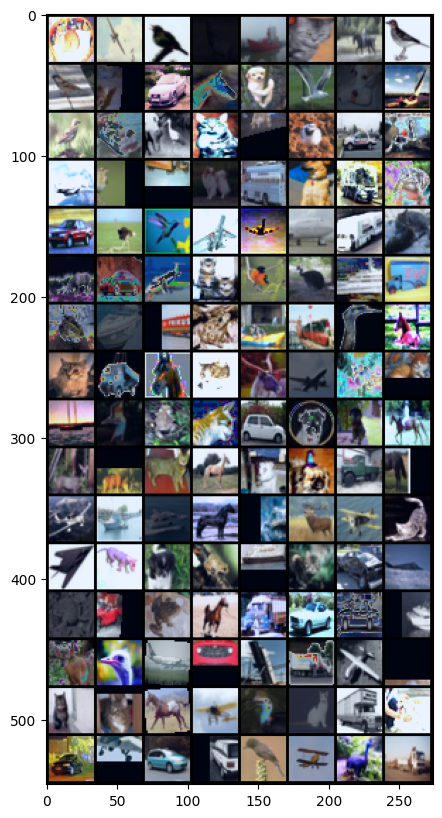

In [15]:
plt.figure(figsize = (20, 10))
out = torchvision.utils.make_grid(train_images, 8, normalize=True)
_ = plt.imshow(out.numpy().transpose((1, 2, 0)))

In [16]:
model = ViT(image_size=test_images.shape[2], 
            channels_in=test_images.shape[1],
            patch_size=patch_size,
            hidden_size=128,
            num_layers=8,
            num_heads=8).to(device)

print(model)

ViT(
  (fc_in): Linear(in_features=48, out_features=128, bias=True)
  (blocks): ModuleList(
    (0-7): 8 x TransformerBlock(
      (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (multihead_attn): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
      )
      (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (mlp): Sequential(
        (0): Linear(in_features=128, out_features=256, bias=True)
        (1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (2): ELU(alpha=1.0)
        (3): Linear(in_features=256, out_features=128, bias=True)
      )
    )
  )
  (fc_out): Linear(in_features=128, out_features=10, bias=True)
)


In [18]:
num_model_params = 0
for param in model.parameters():
    num_model_params += param.flatten().shape[0]

print(f'This model has {num_model_params} (approx. {num_model_params//1e6} million) parameters')

This model has 1079818 (approx. 1.0 million) parameters


In [19]:
out = model(test_images.to(device))
out.shape

torch.Size([128, 10])

### Set up optimizer

In [20]:
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

lr_scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer,
                                                    T_max=num_epochs,
                                                    eta_min=0)

In [21]:
loss_fn = nn.CrossEntropyLoss()

### Defining the training process

In [22]:
def train(model, optimizer, loader, device, loss_fn, loss_logger):

    # setting network in training mode
    model.train()

    for i, (x, y) in enumerate(tqdm(loader, leave=False, desc="Training")):
        # forward pass of image through network and get output
        fx = model(x.to(device))

        # calculate loss using loss function
        loss = loss_fn(fx, y.to(device))

        # zero the gradients
        optimizer.zero_grad()
        # backprop
        loss.backward()
        # single optimation step
        optimizer.step()

        # log the loss for plotting
        loss_logger.append(loss.item())

    return model, optimizer, loss_logger

### Defining the testing process

In [23]:
def evaluate(model, device, loader):

    # initialize a counter
    epoch_acc = 0

    # putting network in eval mode
    # dropout layers will be disabled
    # batchnorm layers will stop calculating mean and stdev
    model.eval()

    with torch.no_grad():
        for i, (x, y) in enumerate(tqdm(loader, leave=False, desc="Evaluating")):
            # forward pass of image through network
            fx = model(x.to(device))

            # logging the cumulative sum of acc
            epoch_acc += (fx.argmax(1) == y.to(device)).sum().item()

    return epoch_acc / len(loader.dataset)

### The training process

In [24]:
training_loss_logger = []
val_acc_logger = []
training_acc_logger = []

In [25]:
val_acc = 0
train_acc = 0

# implementing the training loop
pbar = trange(0, num_epochs, leave=False, desc="Epoch")

for epoch in pbar:
    pbar.set_postfix_str('Accuracy: Train %.2f%%, Val %.2f%%' % (train_acc * 100, val_acc * 100))

    # calling training func and pass training dataloader etc
    model, optimizer, training_loss_logger = train(model=model,
                                                   optimizer=optimizer,
                                                   loader=train_loader,
                                                   device=device,
                                                   loss_fn=loss_fn,
                                                   loss_logger=training_loss_logger)
    
    
    # calling eval function and passing dataloader for both val and training
    train_acc = evaluate(model=model, device=device, loader=train_loader)
    val_acc = evaluate(model=model, device=device, loader=val_loader)

    # logging train and validation accuracies
    val_acc_logger.append(val_acc)
    training_acc_logger.append(train_acc)

    # reducing learning rate
    lr_scheduler.step()

print("Training Complete")

Epoch:   0%|          | 0/50 [00:00<?, ?it/s]

Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Training Complete


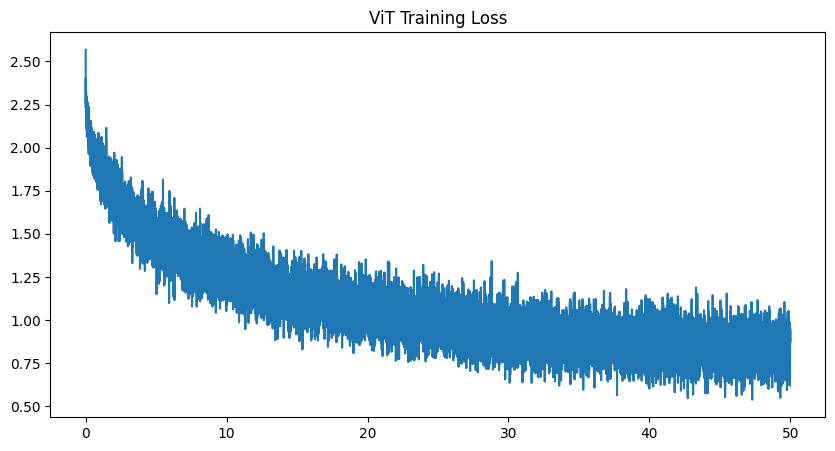

In [26]:
plt.figure(figsize = (10, 5))
train_x = np.linspace(0, num_epochs, len(training_loss_logger))
plt.plot(train_x, training_loss_logger)
_ = plt.title("ViT Training Loss")

/tmp/ipykernel_1285/157005512.py:7: UserWarning: Legend does not support handles for str instances.
A proxy artist may be used instead.
See: https://matplotlib.org/stable/users/explain/axes/legend_guide.html#controlling-the-legend-entries
  _ = plt.legend('Training accuracy', 'Val accuracy')


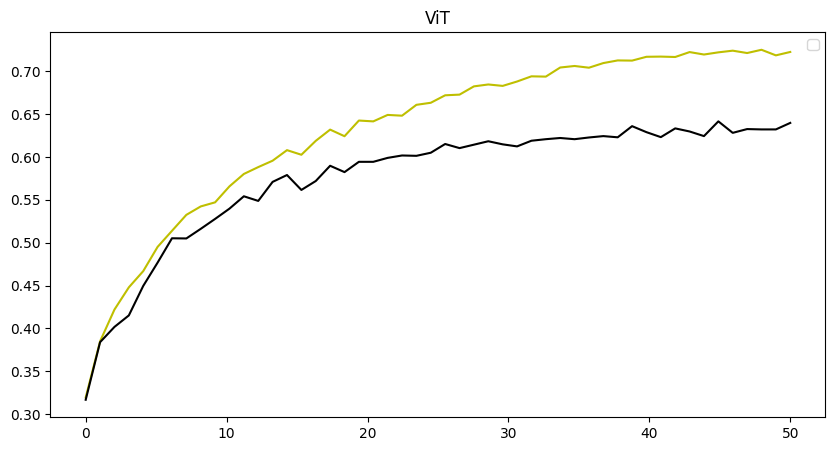

In [28]:
plt.figure(figsize = (10, 5))
train_x = np.linspace(0, num_epochs, len(training_acc_logger))
plt.plot(train_x, training_acc_logger, c = 'y')
valid_x = np.linspace(0, num_epochs, len(val_acc_logger))
plt.plot(valid_x, val_acc_logger, c = 'k')
plt.title('ViT')
_ = plt.legend('Training accuracy', 'Val accuracy')

### Evaluate

In [29]:
# calling the evalutate fn and passing eval/test dataloader etc
test_acc = evaluate(model=model, device=device, loader=test_loader)
print("The total test accuracy is: %.2f%%" %(test_acc * 100))

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

The total test accuracy is: 71.01%


Predicted Values
 [3, 8, 8, 0, 6, 6, 1, 6]
True Values
 [3, 8, 8, 0, 6, 6, 1, 6]


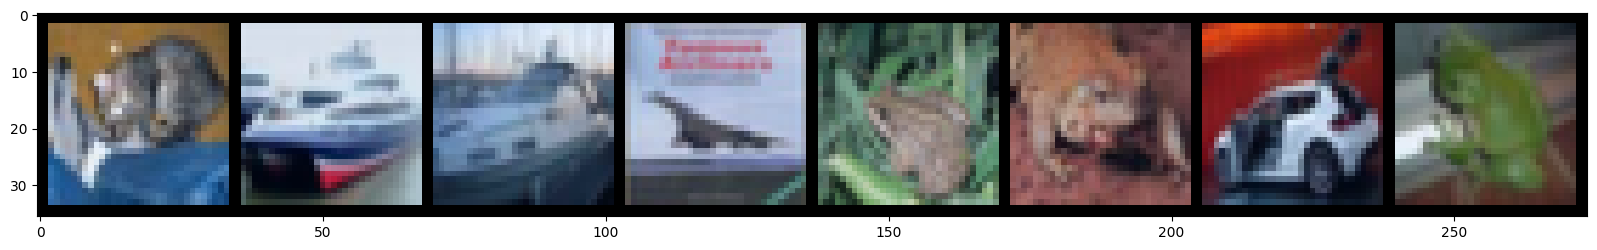

In [30]:
# visualising the prediction for a few test images
with torch.no_grad():
    fx = model(test_images[:8].to(device))
    pred = fx.argmax(-1)

plt.figure(figsize = (20, 10))
out = torchvision.utils.make_grid(test_images[:8], 8, normalize=True)
plt.imshow(out.numpy().transpose((1, 2, 0)))

print('Predicted Values\n', list(pred.cpu().numpy()))
print('True Values\n', list(test_labels[:8].numpy()))

### Visualising The Positional Embeddings

In [32]:
# extracting the positional embeddings
pos_embs = model.pos_embedding.detach().cpu()
# calculating the cosine similarity between every positional embedding
dist = F.cosine_similarity(pos_embs, pos_embs.reshape(64, 1, 128), dim=-1).numpy()

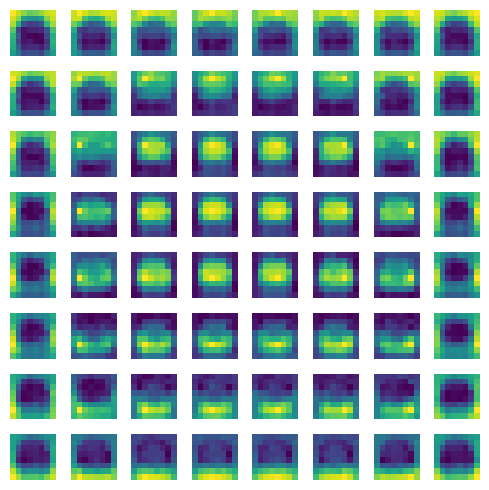

In [33]:
n_rows_cols = 32//patch_size
fig, axes = plt.subplots(n_rows_cols, n_rows_cols, figsize=(5, 5))
for i in range(n_rows_cols):
    for j in range(n_rows_cols):
        img = dist[j + i * n_rows_cols].reshape(n_rows_cols, n_rows_cols)

        # displaying image
        axes[i, j].imshow(img)
        axes[i, j].axis('off') # hiding axis

# adjusting layout and showing grid
plt.tight_layout()
plt.show()